In [2]:
# 基础库文件，用于数据处理
import numpy as np
import pandas as pd
# 画图文件
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

首先，我们先读取一下数据，看看数据是什么样子的。

In [3]:
def missing(df):
    """
    这个是直接查看缺失值所占百分比，比 df.info() 更直观
    会在后面的缺失值处理中用得到
    """
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/len(df)*100).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1)
    return missing_values

# 读取文件，并查看前 5 行数据
df = pd.read_csv('data/train.csv')
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


大概看一下，知道数据都是什么样的，然后我们进行下一步：数据预处理--异常值处理

In [4]:
# 这里用 describe，主要是最大与最小确定是否为合理区间。
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


1. 对于 PassengerID，这一列没多大意义只是表示序号，因此后面可以考虑删掉。
2. 对于 Survived，这是我们要预测的。
3. 对于 Pclass，这是乘客的舱位等级，1表示头等舱，2表示二等舱，3表示三等舱。只要没有其他数字就行。
4. 对于 Slibsp 与 parch，分别表示 登船的兄弟姐妹/配偶人数 和 登船的父母/子女人数。没有负数就行。

因此，我们现在来看看 Age 列，看看有没有异常值。

In [5]:
# 在数据中可以注意到，有小于1岁的乘客，这值得怀疑一下，因此我们看看有哪些小于1岁的乘客
print(f"小于1岁的乘客数量为:{(df['Age']<1).sum()}")
df[df['Age']<1]

小于1岁的乘客数量为:7


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


可以看见，小家伙们活的都很好。这是好事，数据反映了年龄小的可能活下来的概率更大，也符合我们的认知。同时我们观察了其他的特征(主要是 sibsp 与 parch，分别表示 登船的兄弟姐妹/配偶人数 和 登船的父母/子女人数 )，对于小家伙们也是正常的，没有出现某个小家伙的parch=0。

<Axes: >

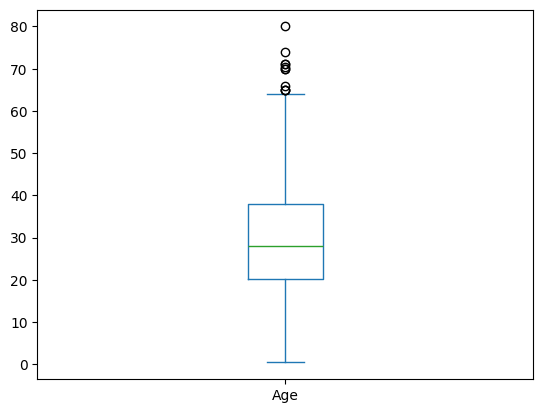

In [6]:
# 如果不放心，也可以用下列方法绘制箱线图
# 但尽管箱线图中显示出了异常值，但是根据业务背景，我们所分析的是游轮乘客
# 因此 65~80 的异常值在我们的背景下是合理的，不用处理
# 贸然删除，可能导致信息的丢失，这对后续的模型训练是不利的
df['Age'].plot.box()

接下来，我们来看Fare这列的数据。对于票价，我们可以上网查询当年的情况，如下：
1. 三等舱：7.5英镑，当时大多数游客的选择。
2. 二等舱: 12英镑。
3. 一等舱: 30~870英镑不等。

但是我们发现，对于Fare这一列居然有小于7.5英镑的价格，这让我们感到疑惑，因此我们不妨来看看。

In [7]:
print(f"房价小于7.5英镑的乘客数量为:{(df['Fare']<7.5).sum()}")
print(f"比例:{(df['Fare']<7.5).sum()/len(df)*100.:2f}%")

房价小于7.5英镑的乘客数量为:87
比例:9.764310%


可以发现，票价小于7.5英镑的乘客人数为87，占比小。如果人数比较多，可能还会怀疑是不是我们信息收集有误。因此我们不妨考虑处理下这些不合理的数据，清洗出更合理的数据。

In [8]:
# 将票价小于7.5英镑的乘客设置为 nan 缺失值。
# 这样放到后面和其他缺失值一起处理。
df['Fare'] = np.where(df['Fare']<7.5, np.nan, df['Fare'])

处理完了异常值，接下来我们再来看看数据预处理中--缺失值处理

In [9]:
# 调用 missing 函数，查看缺失值情况
missing(df)

,0,1
Cabin,687,77.104377
Age,177,19.865320
Fare,87,9.764310
Embarked,2,0.224467
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000


1. 对于 Cabin，这一列缺失值太多，因此我们直接删掉。
2. 对于 Age，这一列缺失值不少也不多，稍后我们来决定如何处理。
3. 对于 Fare，是我们自行造出的缺失值，同样我们在下面决定如何处理。
4. 对于 Embarked，这一列缺失值也不多，直接众数填就好了

In [10]:
# 如上，直接把 Cabin 数据删了就是。
df.drop(columns=['Cabin'],inplace=True)

# Fare 是我们在异常值处理中处理出来的。
# 我们观察发现 Fare 与 Pclass 是有关的。不同的 Pclass 对应不同的 Fare。
# 同时 Pclass 还没有缺失值，简直是天大的好事。
# 因此我们考虑借 Pclass 来填补 Fare 的缺失值。使用不同分组的均值填补
print(df.groupby('Pclass')['Fare'].mean())
df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.mean()))

# Embarked处理
print(df['Embarked'].mode()[0])
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

Pclass
1    86.535298
2    21.358661
3    14.932630
Name: Fare, dtype: float64
S


In [11]:
# 对于 Age 数据，其实操作空间比较大，因为有很多缺失值的处理方式。
# 我们认为年龄可能会较大的影响判断
# 比如刚刚的小家伙们就全部活下来了，而老人可能就像电影里一样。
# 因此我们选择用 KNN 插补法

# 不过在此之前，我们需要做一些处理，避免字符和一些其他的特征影响 KNN 计算
genders = {'male': 0, 'female': 1}
start_pos = {'S': 0, 'C': 1, 'Q': 2}
df['Sex'] = df['Sex'].map(genders)
df['Embarked'] = df['Embarked'].map(start_pos)

df.drop(columns=['PassengerId','Name','Ticket'],inplace=True)

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df['Age'] = imputer.fit_transform(df[['Age']])

In [12]:
# 我们再看一下 missing
missing(df)

,0,1
Survived,0,0.0
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


In [13]:
# 再看一下数据信息
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,33.617889,0.361392
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.442771,0.635673
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,7.520800,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,8.781250,0.000000
50%,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,15.000000,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


此时缺失值就处理完成了。接下来就该到特征工程了

这里我们进行一个简单的特征工程，注意到 SibSp 与 Parch 是有关联的，因此我们将其合并

如果用乘法，可能会导致很多0。除法，分母又不能为0。减法感觉没加法好，因此我们选择加法。

family = Sibsp + Parch 

In [14]:
df['family'] = df['SibSp'] + df['Parch']
df['family'].describe()

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: family, dtype: float64

In [15]:
df.shape

(891, 9)

此时，我们就得到了一个拥有 891 个样本，9 个特征的数据集了。
我们将上面的操作打包成函数，因为我们需要测试集也经过相同的处理。否则无法训练

In [16]:
def DataPreprocessing(df):
    # 异常值处理
    df['Fare'] = np.where(df['Fare']<7.5, np.nan, df['Fare'])
        
    # 特征丢弃
    df.drop(columns=['Cabin','PassengerId','Name','Ticket'],inplace=True)
    
    # 特征编码
    genders = {'male': 0, 'female': 1}
    start_pos = {'S': 0, 'C': 1, 'Q': 2}
    df['Sex'] = df['Sex'].map(genders)
    df['Embarked'] = df['Embarked'].map(start_pos)
    
    # 缺失值处理
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.mean()))

    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    imputer = KNNImputer(n_neighbors=5)
    df['Age'] = imputer.fit_transform(df[['Age']])
    
    # 特征构造
    df['family'] = df['SibSp'] + df['Parch']
    return df

In [17]:
# 测试集处理
# 测试集只要特征比训练集少1，基本就没问题
test  = pd.read_csv('data/test.csv')
test = DataPreprocessing(test)
print(test.shape)

(418, 8)


评价标准选择

Survived
0    549
1    342
Name: count, dtype: int64


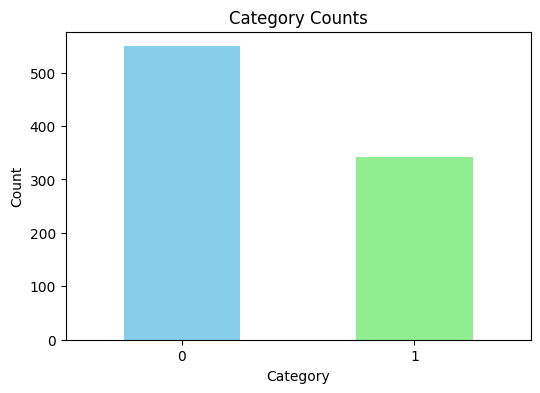

In [18]:
# 观察二分类分布情况，决定使用什么评价标准和数据集划分方式
import matplotlib.pyplot as plt

# 统计该列的二分类别数目
TRcategory_counts = df['Survived'].value_counts()
print(TRcategory_counts)

# 使用 matplotlib 绘制柱状图
plt.figure(figsize=(6,4))
TRcategory_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

可以看出，这是一个偏斜的二分类问题。因此我们选择K折交叉来划分训练集，同时选择交叉验证 AUC 分数评估模型性能。

In [19]:
SEED = 42

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X = df.drop(columns=['Survived'],axis=1).values
y = df['Survived'].values

# n_splits=5，表示划分为 5 个部分
# shuffle，表示每次划分之间随机打乱数据
# random_state，明确 shuffle 随机打乱的种子，方便后续复现
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)

# 创建随机森林模型
model = RandomForestClassifier(random_state=SEED)

# 初始化存储每一折的 AUC 值
auc_scores = []

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    # 在测试集上预测概率（使用 predict_proba 而不是 predict）
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # 获取正类的预测概率
    
    # 计算 AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # 将每一折的 AUC 添加到 auc_scores 中
    auc_scores.append(auc)

# 输出每一折的 AUC 和平均 AUC
print("每一折的 AUC:", auc_scores)
print("平均 AUC:", np.mean(auc_scores))
    

每一折的 AUC: [0.8876152832674572, 0.8601604278074866, 0.8367647058823531, 0.8541443850267381, 0.8808004254753358]
平均 AUC: 0.8638970454918742


In [21]:
# 获得最终结果
model.fit(X,y)
Y_pred = model.predict(test)

# 读取结果
res = pd.read_csv('data/gender_submission.csv')

# 计算准确率(假设 gender_submission.csv 是 Kaggle 提供的答案)
ac = (res['Survived'] == Y_pred).sum()/len(res)
print(ac)

0.8014354066985646


In [22]:
# 保存结果
finaldata = pd.DataFrame({
    'PassengerId': res['PassengerId'],
    'Survived': Y_pred
})

finaldata.to_csv('data/reslut.csv', index=False)
print("OK!")

OK!
